In [ ]:
# Start by importing all the things we'll need.
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, CuDNNLSTM, Flatten, TimeDistributed, Dropout, LSTMCell, RNN, Bidirectional, Concatenate, Layer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import tf_utils
from tensorflow.keras import backend as K

import unicodedata
import re
import numpy as np
import os
import time
import shutil

import pandas as pd
import numpy as np
import string, os 
tf.__version__

'1.14.0'

In [ ]:
# Importing the english text corpus
file = open("./data.txt", 'r')
corpus = [line for line in file]

In [ ]:
# Sample sentences
corpus[0:10]

['\ufeffHey, place the toolbox in the truck!\n',
 '\n',
 'Hey, what are you doing here?\n',
 '\n',
 'Hey, give me a break.\n',
 '\n',
 'Hey, John.\n',
 '\n',
 "Hey, what are you doing? Don't touch it, or you'll break the balance!\n",
 '\n']

In [ ]:
# Removing punctuation from the sentences
def clean_special_chars(text, punct):
    for p in punct:
        text = text.replace(p, '')
    return text

# Calling function to remove the punctuation and turning data into lower case      
def preprocess(data):
    output = []
    punct = '#$%&*+-/<=>@[\\]^_`{|}~\t\n'
    for line in data:
         pline= clean_special_chars(line.lower(), punct)
         output.append(pline)
    return output  

# Convert the sentence to char gram
def generate_dataset():
    processed_corpus = preprocess(corpus)    
    output = []
    for line in processed_corpus:
        token_list = line
        for i in range(1, len(token_list)):
            data = []
            x_ngram = '<start> '+ token_list[:i+1] + ' <end>'
            y_ngram = '<start> '+ token_list[i+1:] + ' <end>'
            data.append(x_ngram)
            data.append(y_ngram)
            output.append(data)
    print("Dataset prepared with prefix and suffixes for teacher forcing technique")
    dummy_df = pd.DataFrame(output, columns=['input','output'])
    return output, dummy_df

In [ ]:
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
        self.vocab = sorted(self.vocab)
        self.word2idx["<pad>"] = 0
        self.idx2word[0] = "<pad>"
        for i,word in enumerate(self.vocab):
            self.word2idx[word] = i + 1
            self.idx2word[i+1] = word

def max_length(t):
    return max(len(i) for i in t)

def load_dataset():
    pairs,df = generate_dataset()
    out_lang = LanguageIndex(sp for en, sp in pairs)
    in_lang = LanguageIndex(en for en, sp in pairs)
    input_data = [[in_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    output_data = [[out_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]

    max_length_in, max_length_out = max_length(input_data), max_length(output_data)
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_data, maxlen=max_length_in, padding="post")
    output_data = tf.keras.preprocessing.sequence.pad_sequences(output_data, maxlen=max_length_out, padding="post")
    return input_data, output_data, in_lang, out_lang, max_length_in, max_length_out, df

In [ ]:
# Preprocess the prepare the data
input_data, teacher_data, input_lang, target_lang, len_input, len_target, df = load_dataset()


target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))

# Shuffle all of the data in unison. This training set has the longest (e.g. most complicated) data at the end,
# so a simple Keras validation split will be problematic if not shuffled.

p = np.random.permutation(len(input_data))
input_data = input_data[p]
teacher_data = teacher_data[p]
target_data = target_data[p]

Dataset prepared with prefix and suffixes for teacher forcing technique


In [ ]:
# Set the parameter to train the model
pd.set_option('display.max_colwidth', -1)
BUFFER_SIZE = len(input_data)
BATCH_SIZE = 128
embedding_dim = 300
units = 128
vocab_in_size = len(input_lang.word2idx)
vocab_out_size = len(target_lang.word2idx)
df.iloc[60:65]

,input,output
60,"<start> hey, what are you doing he <end>",<start> re? <end>
61,"<start> hey, what are you doing her <end>",<start> e? <end>
62,"<start> hey, what are you doing here <end>",<start> ? <end>
63,"<start> hey, what are you doing here? <end>",<start> <end>
64,<start> he <end>,"<start> y, give me a break. <end>"


In [ ]:
# Create the Encoder layers first.
encoder_inputs = Input(shape=(len_input,))
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim)

# Use this if you dont need Bidirectional LSTM
# encoder_lstm = CuDNNLSTM(units=units, return_sequences=True, return_state=True)
# encoder_out, state_h, state_c = encoder_lstm(encoder_emb(encoder_inputs))

encoder_lstm = Bidirectional(CuDNNLSTM(units=units, return_sequences=True, return_state=True))
encoder_out, fstate_h, fstate_c, bstate_h, bstate_c = encoder_lstm(encoder_emb(encoder_inputs))

state_h = Concatenate()([fstate_h,bstate_h])
state_c = Concatenate()([bstate_h,bstate_c])
encoder_states = [state_h, state_c]


# Now create the Decoder layers.
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = CuDNNLSTM(units=units*2, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)
# Two dense layers added to this model to improve inference capabilities.
decoder_d1 = Dense(units, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
decoder_out = decoder_d2(Dropout(rate=.2)(decoder_d1(Dropout(rate=.2)(decoder_lstm_out))))


# Finally, create a training model which combines the encoder and the decoder.
# Note that this model has three inputs:
model = Model(inputs = [encoder_inputs, decoder_inputs], outputs= decoder_out)

# We'll use sparse_categorical_crossentropy so we don't have to expand decoder_out into a massive one-hot array.
# Adam is used because it's, well, the best.

model.compile(optimizer=tf.train.AdamOptimizer(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 113)]        0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 113, 300)     1168800     input_23[0][0]                   
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional_11 (Bidirectional [(None, 113, 256), ( 440320      embedding_22[0][0]               
___________________________________________________________________________________________

In [ ]:
# Note, we use 20% of our data for validation.
epochs = 10
history = model.fit([input_data, teacher_data], target_data,
                 batch_size= BATCH_SIZE,
                 epochs=epochs,
                 validation_split=0.2)

Train on 30010 samples, validate on 7503 samples
Epoch 1/10
30010/30010 [==============================] - 41s 1ms/sample - loss: 0.7521 - sparse_categorical_accuracy: 0.9382 - val_loss: 0.3241 - val_sparse_categorical_accuracy: 0.9475
Epoch 2/10
30010/30010 [==============================] - 40s 1ms/sample - loss: 0.2960 - sparse_categorical_accuracy: 0.9496 - val_loss: 0.2655 - val_sparse_categorical_accuracy: 0.9518
Epoch 3/10
30010/30010 [==============================] - 40s 1ms/sample - loss: 0.2372 - sparse_categorical_accuracy: 0.9554 - val_loss: 0.2028 - val_sparse_categorical_accuracy: 0.9633
Epoch 4/10
30010/30010 [==============================] - 40s 1ms/sample - loss: 0.1880 - sparse_categorical_accuracy: 0.9638 - val_loss: 0.1576 - val_sparse_categorical_accuracy: 0.9718
Epoch 5/10
30010/30010 [==============================] - 40s 1ms/sample - loss: 0.1521 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.1280 - val_sparse_categorical_accuracy: 0.9767
Epoch 6/10
30010

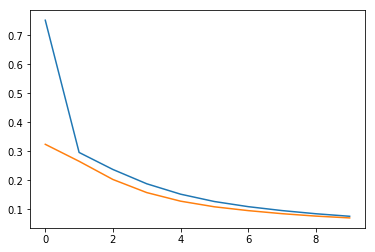

In [ ]:
# Plot the results of the training.
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.show()

In [ ]:
# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_out, state_h, state_c])

# Generate a new set of tensors for our new inference decoder. Note that we are using new tensors, 
# this does not preclude using the same underlying layers that we trained on. (e.g. weights/biases).

inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")
# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units*2,), name="state_input_h")
state_input_c = Input(shape=(units*2,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))
inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])

In [ ]:
# Converts the given sentence (just a string) into a vector of word IDs
# Output is 1-D: [timesteps/words]

def sentence_to_vector(sentence, lang):

    pre = sentence
    vec = np.zeros(len_input)
    sentence_list = [lang.word2idx[s] for s in pre.split(' ')]
    for i,w in enumerate(sentence_list):
        vec[i] = w
    return vec

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
def translate(input_sentence, infenc_model, infmodel):
    sv = sentence_to_vector(input_sentence, input_lang)
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vec = target_lang.word2idx["<start>"]
    stop_vec = target_lang.word2idx["<end>"]
    
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "<start>"
    output_sentence = ""

    while cur_word != "<end>" and i < (len_target-1):
        i += 1
        if cur_word != "<start>":
            output_sentence = output_sentence + " " + cur_word
        x_in = [cur_vec, sh, sc]
        [nvec, sh, sc] = infmodel.predict(x=x_in)
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = target_lang.idx2word[np.argmax(nvec[0,0])]
    return output_sentence

In [ ]:
#Note that only words that we've trained the model on will be available, otherwise you'll get an error.


test = [
    'What are',
    'Thank you',
    'Have a',
    'See',
    'How old',
]
  

import pandas as pd
output = []  
for t in test:  
  output.append({"Input seq":t.lower(), "Pred. Seq":translate(t.lower(), encoder_model, inf_model)})

results_df = pd.DataFrame.from_dict(output) 
results_df.head(len(test))

,Input seq,Pred. Seq
0,what are,you going?
1,thank you,you for the consideration you will give to our request.
2,have a,wonderful eating experience.
3,see,you next week.
4,how old,are you doing? it's been a long time since i've seen you.
